# Problem 1

Approx. final values (from V_A): {'s1': 3.2276783037249324, 's2': 22.095602832027502}
Approx. final values (from V_B): {'s1': 3.364221922983738, 's2': 22.232146451285622}


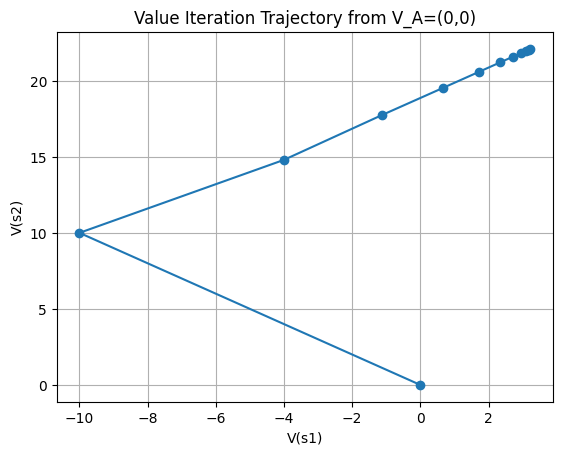

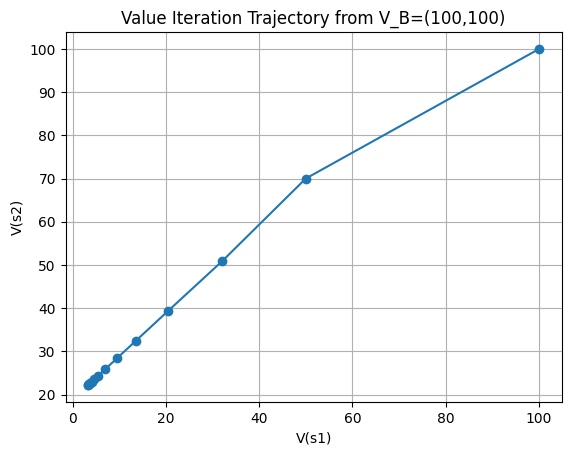

In [1]:
import matplotlib.pyplot as plt
import numpy as np

############################
# 1. Define the MDP
############################

states = ["s1","s2"]
actions = ["a1","a2","a3"]
gamma = 0.6

# Rewards:
R = {"s1": -10,  # R(s1)
     "s2":  10}  # R(s2)

# Transition probabilities: P(s' | s, a)
P = {}
# We store P in a dict so that P[("s1","a1")] is a dict of next states -> probabilities.
# For example: P[("s1","a1")] = {"s1":0.2, "s2":0.8}.
P[("s1","a1")] = {"s1":0.2, "s2":0.8}
P[("s1","a2")] = {"s1":0.4, "s2":0.6}
P[("s1","a3")] = {"s2":1.0}    # from s1 via a3 → s2 w.p.1

P[("s2","a1")] = {"s1":0.1, "s2":0.9}
# from s2 via a2 → no next states, so prob=0 for everything
P[("s2","a2")] = {}
P[("s2","a3")] = {"s1":0.5, "s2":0.5}

############################
# 2. Bellman Update
############################

def bellman_update(V_old):
    """
    Given current values V_old = (V_old(s1), V_old(s2)),
    return the next value vector V_new by max over actions.
    """
    # We'll store in a dict: V_new["s1"], V_new["s2"].
    V_new = {}
    
    for s in states:
        # For each action, compute Q(s,a) = R(s) + gamma * sum_{s'} P(s'|s,a) * V_old(s')
        Q_values = []
        for a in actions:
            # Sum over next states
            # If P[(s,a)] not found or empty, the sum is 0
            trans_dict = P.get((s,a), {})
            exp_val = 0.0
            for s_next, prob_s_next in trans_dict.items():
                exp_val += prob_s_next * V_old[s_next]
            
            Q_sa = R[s] + gamma * exp_val
            Q_values.append(Q_sa)
        
        # Now choose the best action
        V_new[s] = max(Q_values)
    
    return V_new

def max_norm_diff(V1, V2):
    """Compute the max-norm difference between two value dictionaries."""
    return max(abs(V1["s1"] - V2["s1"]), abs(V1["s2"] - V2["s2"]))

############################
# 3. Value Iteration from two initial values
############################

def value_iteration(V_init, tolerance=0.1):
    """
    Perform value iteration starting from V_init (a dict {s1->..., s2->...})
    until the result is within `tolerance` (in max norm) of convergence 
    *to the optimal fixed point*.
    
    In practice here, we will just keep iterating 
    until the difference between consecutive iterations is small enough
    to ensure we are within 0.1 of the fixed point.
    """
    # Keep track of the sequence for plotting
    trajectory = []

    V_current = dict(V_init)  # copy
    while True:
        trajectory.append( (V_current["s1"], V_current["s2"]) )

        # Bellman update
        V_next = bellman_update(V_current)
        
        # Check difference
        diff = max_norm_diff(V_current, V_next)
        
        V_current = V_next
        if diff < 0.05: 
            # A small enough threshold to ensure we're within 0.1 of V* 
            # (because each Bellman update shrinks errors by a factor gamma <= 0.6).
            break

    # Record final
    trajectory.append( (V_current["s1"], V_current["s2"]) )
    return V_current, trajectory

############################
# 4. Run from V_A and V_B
############################

# (a) Start from (0, 0)
V_init_A = {"s1": 0.0, "s2": 0.0}
V_star_A, trajA = value_iteration(V_init_A)

# (b) Start from (100, 100)
V_init_B = {"s1": 100.0, "s2": 100.0}
V_star_B, trajB = value_iteration(V_init_B)

print("Approx. final values (from V_A):", V_star_A)
print("Approx. final values (from V_B):", V_star_B)

############################
# 5. Plotting trajectories
############################

# Convert to arrays for plotting
trajA = np.array(trajA)
trajB = np.array(trajB)

# Plot 1: Trajectory from V_A
plt.figure()
plt.title("Value Iteration Trajectory from V_A=(0,0)")
plt.plot(trajA[:,0], trajA[:,1], marker='o')
plt.xlabel("V(s1)")
plt.ylabel("V(s2)")
plt.grid(True)
plt.show()

# Plot 2: Trajectory from V_B
plt.figure()
plt.title("Value Iteration Trajectory from V_B=(100,100)")
plt.plot(trajB[:,0], trajB[:,1], marker='o')
plt.xlabel("V(s1)")
plt.ylabel("V(s2)")
plt.grid(True)
plt.show()


# Problem 3


Final Q-values for state D0 (row 2, lane 0):
Action 'Move 1': Q-value = 6.170
Action 'Move 2': Q-value = 7.999
Action 'Switch and Move': Q-value = 6.188
Action 'No Move': Q-value = 6.133


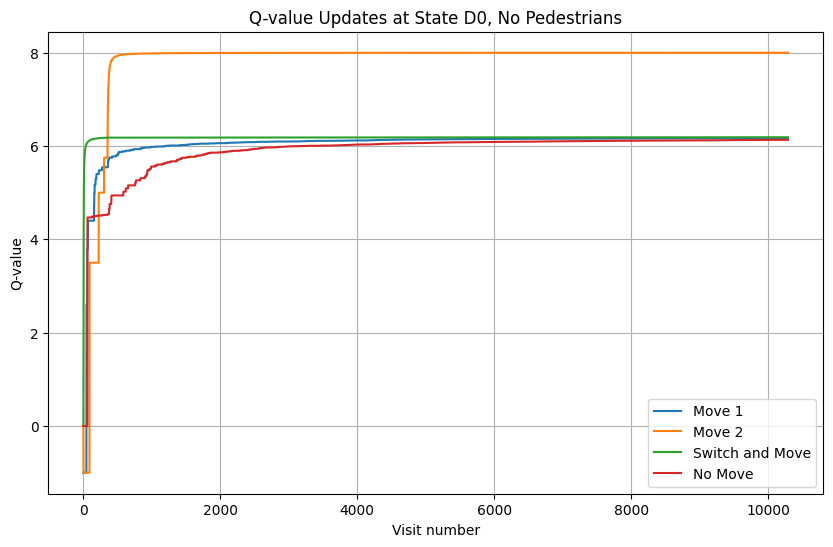

In [48]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------------------
# Environment without pedestrians
# ---------------------------
class SafeDrivingEnvNoPed:
    def __init__(self):
        # Grid dimensions
        self.CAR_ROWS = 7   # Rows 0 (start) to 6 (parking)
        self.CAR_COLS = 2   # Two lanes (0 and 1)
        # Define actions
        self.actions = ["Move 1", "Move 2", "Switch and Move", "No Move"]
        # Rewards
        self.step_penalty = -1
        self.finish_reward = 10   # Reward for parking
        
    def reset(self):
        """Start in row 0 at a random lane."""
        start_lane = random.choice([0, 1])
        return (0, start_lane)  # state: (row, lane)
    
    def get_next_state(self, state, action):
        """Compute the next state from current state and action (deterministic)."""
        row, lane = state
        
        if action == "Move 1":
            new_row = min(row + 1, self.CAR_ROWS - 1)
            new_lane = lane
        elif action == "Move 2":
            # When moving down 2 cells, if possible, the car occupies both intermediate and destination.
            if row + 2 <= self.CAR_ROWS - 1:
                new_row = row + 2
            else:
                new_row = self.CAR_ROWS - 1
            new_lane = lane
        elif action == "Switch and Move":
            new_lane = 1 - lane  # switch lane (from 0 to 1 or 1 to 0)
            new_row = min(row + 1, self.CAR_ROWS - 1)
        elif action == "No Move":
            new_row = row
            new_lane = lane
        else:
            raise ValueError("Invalid action")
        
        return (new_row, new_lane)
    
    def get_reward(self, state):
        """Return the reward for the given state."""
        row, lane = state
        if row == self.CAR_ROWS - 1:  # parking cells P1/P2 (row 6)
            return self.finish_reward
        return self.step_penalty


# ---------------------------
# Q-Learning Agent for No-Ped Environment
# ---------------------------
class QLearningAgentNoPed:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Q-table shape: (CAR_ROWS, CAR_COLS, number of actions)
        shape = (env.CAR_ROWS, env.CAR_COLS, len(env.actions))
        self.Q = np.zeros(shape)
        self.visit_counts = np.zeros(shape)  # For per-(s,a) learning rate tracking
        
        # Designated state D0 for tracking updates
        self.D0 = (2, 0)  # e.g., row 2, lane 0
        self.history = []  # To record Q-table snapshots at D0
    
    def choose_action(self, state):
        """Select an action using ε–greedy strategy."""
        row, lane = state
        if random.random() < self.epsilon:
            return random.randint(0, len(self.env.actions) - 1)
        else:
            return int(np.argmax(self.Q[row, lane, :]))
    
    def q_learning_episode(self, max_steps=50):
        state = self.env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            steps += 1
            row, lane = state
            action_index = self.choose_action(state)
            action = self.env.actions[action_index]
            
            # Transition to next state
            next_state = self.env.get_next_state(state, action)
            reward = self.env.get_reward(next_state)
            total_reward += reward
            
            # Terminal if reached parking
            if next_state[0] == self.env.CAR_ROWS - 1:
                self.Q[row, lane, action_index] = reward
                done = True
            else:
                # Increment visit count for (state, action) and compute learning rate
                self.visit_counts[row, lane, action_index] += 1
                alpha = 1.0 / self.visit_counts[row, lane, action_index]
                
                next_row, next_lane = next_state
                target = reward + self.gamma * np.max(self.Q[next_row, next_lane, :])
                self.Q[row, lane, action_index] = (
                    (1 - alpha) * self.Q[row, lane, action_index] + alpha * target
                )
            
            # If we are in state D0, record Q-value snapshot for all actions.
            if state == self.D0:
                self.history.append(self.Q[self.D0[0], self.D0[1], :].copy())
            
            state = next_state
        
        return total_reward
    
    def run_q_learning(self, episodes=10000, max_steps=50):
        """Run Q-learning over a number of episodes.
        
        Returns:
            history: A list of Q-value snapshots for state D0.
            rewards: List of cumulative rewards per episode.
        """
        rewards = []
        for ep in range(episodes):
            episode_reward = self.q_learning_episode(max_steps=max_steps)
            rewards.append(episode_reward)
        return self.history, rewards


# ---------------------------
# Running Q-Learning and Plotting Results
# ---------------------------
env = SafeDrivingEnvNoPed()
agent = QLearningAgentNoPed(env, gamma=0.9, epsilon=0.1)

num_actions = len(env.actions)
# Run Q-learning
history, rewards = agent.run_q_learning(episodes=20000, max_steps=50)

# Extract the final Q-values for state D0 (row 2, lane 0)
final_Q_values_D0 = agent.Q[agent.D0[0], agent.D0[1], :]

# Print final Q-values for each action
print("\nFinal Q-values for state D0 (row 2, lane 0):")
for action, q_value in zip(env.actions, final_Q_values_D0):
    print(f"Action '{action}': Q-value = {q_value:.3f}")

# Extract the Q-value trajectories for the designated state D0
D0_q_history = np.array(history)  # shape: (number_of_visits, number_of_actions)

# Plot Q-value updates at D0
plt.figure(figsize=(10,6))
for a in range(num_actions):
    plt.plot(D0_q_history[:, a], label=env.actions[a])
plt.xlabel("Visit number")
plt.ylabel("Q-value")
plt.title("Q-value Updates at State D0, No Pedestrians")
plt.legend()
plt.grid(True)
plt.show()


## With pedestrians


Final Q-values for state D0 (row 2, lane 0) with pedestrians at (6,0):
Action 'Move 1': Q-value = 3.965
Action 'Move 2': Q-value = 6.188
Action 'Switch and Move': Q-value = 4.392
Action 'No Move': Q-value = 4.042


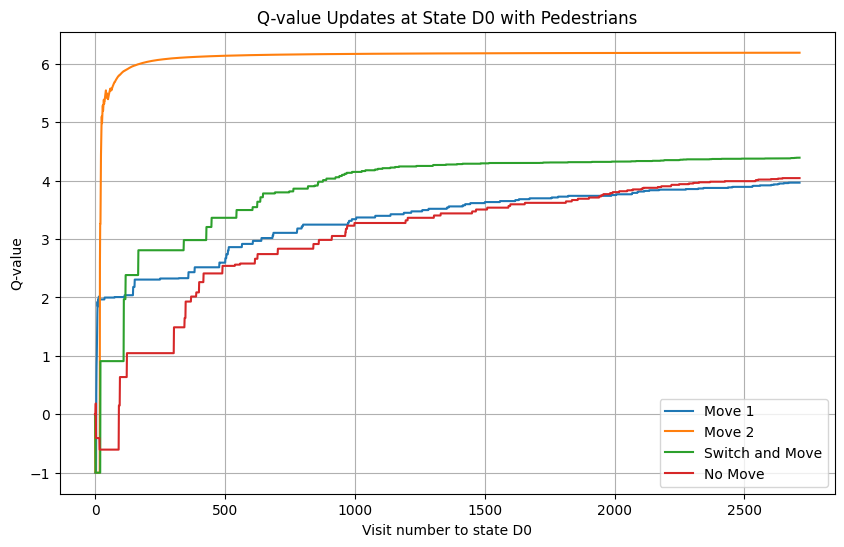

In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------------------------
# Environment with Pedestrians
# ---------------------------
class SafeDrivingEnvWithPed:
    def __init__(self):
        # Grid parameters for the car:
        self.CAR_ROWS = 7   # Rows 0 (start) to 6 (parking)
        self.CAR_COLS = 2   # Two lanes (0 and 1)
        
        # Pedestrian parameters:
        self.PED_ROWS = (3, 4)   # Pedestrians are confined to these rows
        self.PED_COLS = 8        # Number of columns in pedestrian lanes
        
        # Define available actions for the car:
        self.actions = ["Move 1", "Move 2", "Switch and Move", "No Move"]
        
        # Reward definitions:
        self.step_penalty = -1   # For each step not finishing or crashing
        self.finish_reward = 10  # When the car reaches a parking cell (row 6)
        self.crash_reward = -50  # When the car crashes with a pedestrian
        
    def reset(self):
        """Resets the environment to a random starting state.
        
        Returns:
            state: Tuple (car_row, car_col, ped1_col, ped2_col)
        """
        # Car starts at row 0 in a random lane.
        start_lane = random.choice([0, 1])
        # Pedestrians appear in random columns in their rows.
        ped1_col = random.randint(0, self.PED_COLS - 1)
        ped2_col = random.randint(0, self.PED_COLS - 1)
        return (0, start_lane, ped1_col, ped2_col)
    
    def get_next_state(self, state, action):
        """Returns the next state given a current state and car action.
        
        The state is (car_row, car_col, ped1_col, ped2_col). The car's move is
        deterministic. Pedestrians move in their respective rows:
          - Ped1 moves left (subtracting from its column) 1 or 2 cells.
          - Ped2 moves right (adding to its column) 1 or 2 cells.
        Their movement wraps around the pedestrian grid.
        """
        car_row, car_col, ped1_col, ped2_col = state
        # --- Update car's position ---
        if action == "Move 1":
            new_car_row = min(car_row + 1, self.CAR_ROWS - 1)
            new_car_col = car_col
            car_spaces = [(new_car_row, new_car_col)]
        elif action == "Move 2":
            if car_row + 2 <= self.CAR_ROWS - 1:
                new_car_row = car_row + 2
                new_car_col = car_col
                # When moving down 2, assume the car occupies both the intermediate and destination cells.
                car_spaces = [(car_row + 1, new_car_col), (new_car_row, new_car_col)]
            else:
                new_car_row = self.CAR_ROWS - 1
                new_car_col = car_col
                car_spaces = [(new_car_row, new_car_col)]
        elif action == "Switch and Move":
            # Switch lane and move down 1.
            new_car_col = 1 - car_col
            new_car_row = min(car_row + 1, self.CAR_ROWS - 1)
            # When switching, assume the car occupies both the new cell and the one above it.
            car_spaces = [(new_car_row, new_car_col)]
            if new_car_row - 1 >= 0:
                car_spaces.append((new_car_row - 1, new_car_col))
        elif action == "No Move":
            new_car_row, new_car_col = car_row, car_col
            car_spaces = [(new_car_row, new_car_col)]
        else:
            raise ValueError("Invalid action")
        
        # --- Update pedestrians ---
        # Pedestrian 1 (in PED_ROWS[0]) moves left.
        ped1_move = random.choice([1, 2])
        new_ped1_col = (ped1_col - ped1_move) % self.PED_COLS
        # When moving 2, we can assume the pedestrian occupies two adjacent cells.
        if ped1_move == 1:
            ped1_spaces = [(self.PED_ROWS[0], new_ped1_col)]
        else:
            ped1_spaces = [(self.PED_ROWS[0], new_ped1_col),
                           (self.PED_ROWS[0], (new_ped1_col + 1) % self.PED_COLS)]
        
        # Pedestrian 2 (in PED_ROWS[1]) moves right.
        ped2_move = random.choice([1, 2])
        new_ped2_col = (ped2_col + ped2_move) % self.PED_COLS
        if ped2_move == 1:
            ped2_spaces = [(self.PED_ROWS[1], new_ped2_col)]
        else:
            ped2_spaces = [(self.PED_ROWS[1], new_ped2_col),
                           (self.PED_ROWS[1], (new_ped2_col - 1) % self.PED_COLS)]
        
        # --- Check for collision adjustments ---
        # If any cell occupied by the car coincides with a pedestrian cell, we simulate a collision.
        for cell in car_spaces:
            if cell in ped1_spaces:
                # Optionally, you can adjust new_car_row/new_car_col or pedestrian positions.
                # Here, we simply note that a collision occurred.
                break
            if cell in ped2_spaces:
                break
        
        return (new_car_row, new_car_col, new_ped1_col, new_ped2_col)
    
    def get_reward(self, state):
        """Returns the reward for the given state.
        
        - If the car reaches parking (row 6), reward +10.
        - If the car collides with a pedestrian (i.e. if the car is in the same cell as a pedestrian in that row), reward -50.
        - Otherwise, reward -1.
        """
        car_row, car_col, ped1_col, ped2_col = state
        
        # Terminal: car reaches parking (row 6)
        if car_row == self.CAR_ROWS - 1:
            return self.finish_reward
        
        # Crash conditions: if the car is in a pedestrian row and shares the same column.
        if car_row == self.PED_ROWS[0] and car_col == ped1_col:
            return self.crash_reward
        if car_row == self.PED_ROWS[1] and car_col == ped2_col:
            return self.crash_reward
        
        return self.step_penalty


# ---------------------------
# Q-Learning Agent with Pedestrians
# ---------------------------
class QLearningAgentWithPed:
    def __init__(self, env, gamma=0.9, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Q-table dimensions: (CAR_ROWS, CAR_COLS, PED_COLS, PED_COLS, number of actions)
        shape = (env.CAR_ROWS, env.CAR_COLS, env.PED_COLS, env.PED_COLS, len(env.actions))
        self.Q = np.zeros(shape)
        self.visit_counts = np.zeros(shape)  # For per (state, action) learning rates
        
        # Designated state D0 for tracking updates.
        # Here we define D0 as: car at (2, 0) and pedestrians at fixed positions (e.g. (6, 0))
        self.D0 = (2, 0)
        self.D0_PEDs = (6, 0)
        self.history = []  # To record Q-value snapshots for state D0
        
    def choose_action(self, state):
        """Select an action using ε–greedy strategy."""
        car_row, car_col, ped1, ped2 = state
        if random.random() < self.epsilon:
            return random.randint(0, len(self.env.actions) - 1)
        else:
            return int(np.argmax(self.Q[car_row, car_col, ped1, ped2, :]))
    
    def q_learning_episode(self, max_steps=50):
        state = self.env.reset()
        total_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            steps += 1
            car_row, car_col, ped1, ped2 = state
            action_index = self.choose_action(state)
            action = self.env.actions[action_index]
            
            # Determine next state and reward.
            next_state = self.env.get_next_state(state, action)
            reward = self.env.get_reward(state)
            total_reward += reward
            
            # Terminal conditions: finish or crash.
            if reward == self.env.finish_reward or reward == self.env.crash_reward:
                self.Q[car_row, car_col, ped1, ped2, action_index] = reward
                done = True
            else:
                # Update visit count and compute learning rate α = 1/k.
                self.visit_counts[car_row, car_col, ped1, ped2, action_index] += 1
                alpha = 1.0 / self.visit_counts[car_row, car_col, ped1, ped2, action_index]
                next_car_row, next_car_col, next_ped1, next_ped2 = next_state
                target = reward + self.gamma * np.max(self.Q[next_car_row, next_car_col, next_ped1, next_ped2, :])
                self.Q[car_row, car_col, ped1, ped2, action_index] = (
                    (1 - alpha) * self.Q[car_row, car_col, ped1, ped2, action_index] + alpha * target
                )
            
            # If we are at the designated state D0 with fixed pedestrian positions, record a snapshot.
            if state[0] == self.D0[0] and state[1] == self.D0[1] and state[2] == self.D0_PEDs[0] and state[3] == self.D0_PEDs[1]:
                self.history.append(self.Q[self.D0[0], self.D0[1], self.D0_PEDs[0], self.D0_PEDs[1], :].copy())
            
            state = next_state
        
        return total_reward
    
    def run_q_learning(self, episodes=20000, max_steps=50):
        """Run Q-learning for a given number of episodes.
        
        Returns:
            history: Q-value snapshots for state D0.
            rewards: Episode cumulative rewards.
        """
        rewards = []
        for ep in range(episodes):
            ep_reward = self.q_learning_episode(max_steps=max_steps)
            rewards.append(ep_reward)
        return self.history, rewards


# ---------------------------
# Running Q-Learning and Plotting
# ---------------------------
env = SafeDrivingEnvWithPed()
agent = QLearningAgentWithPed(env, gamma=0.9, epsilon=0.1)

# Run Q-learning (adjust episodes as needed)
history, rewards = agent.run_q_learning(episodes=250000, max_steps=50)

# Extract final Q-values for state D0 (car at (2,0), pedestrians at (6,0))
final_Q_values_D0 = agent.Q[agent.D0[0], agent.D0[1], agent.D0_PEDs[0], agent.D0_PEDs[1], :]

# Print final Q-values for each action
print("\nFinal Q-values for state D0 (row 2, lane 0) with pedestrians at (6,0):")
for action, q_value in zip(env.actions, final_Q_values_D0):
    print(f"Action '{action}': Q-value = {q_value:.3f}")

# Extract Q-value trajectories for state D0.
D0_q_values = {action: [] for action in env.actions}
for snapshot in history:
    for i, action in enumerate(env.actions):
        D0_q_values[action].append(snapshot[i])

# Plot the Q-value evolution at state D0.
plt.figure(figsize=(10, 6))
for action in env.actions:
    plt.plot(D0_q_values[action], label=action)
plt.xlabel("Visit number to state D0")
plt.ylabel("Q-value")
plt.title("Q-value Updates at State D0 with Pedestrians")
plt.legend()
plt.grid(True)
plt.show()



# Problem 5

Part 1: Histogram of sample means for X ~ {0,1} with P(0)=0.3, P(1)=0.7

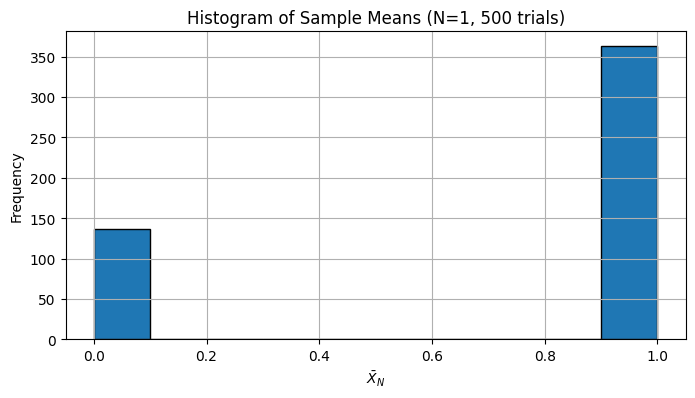

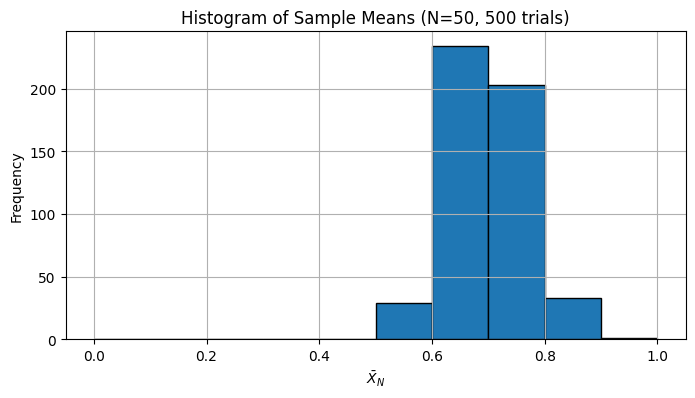

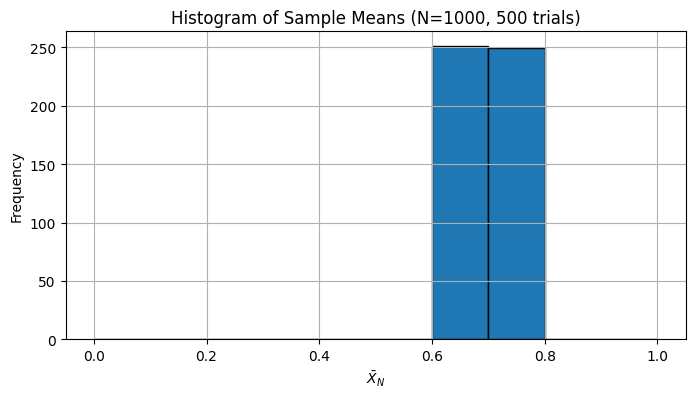

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import random

p0 = 0.3
p1 = 0.7

def sample_X():
    return 0 if random.random() < p0 else 1

N_values = [1, 50, 1000]
num_trials = 500
for N in N_values:
    sample_means = []
    for _ in range(num_trials):
        samples = [sample_X() for _ in range(N)]
        sample_means.append(np.mean(samples))
        
    plt.figure(figsize=(8,4))
    plt.hist(sample_means, bins=np.linspace(0,1,11), edgecolor='black')
    plt.xlabel(r'$\bar{X}_N$')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Sample Means (N={N}, {num_trials} trials)')
    plt.grid(True)
    plt.show()


Part 2: Plot P(|X̄ - μ| >= ε) vs. N compared with Hoeffding bound

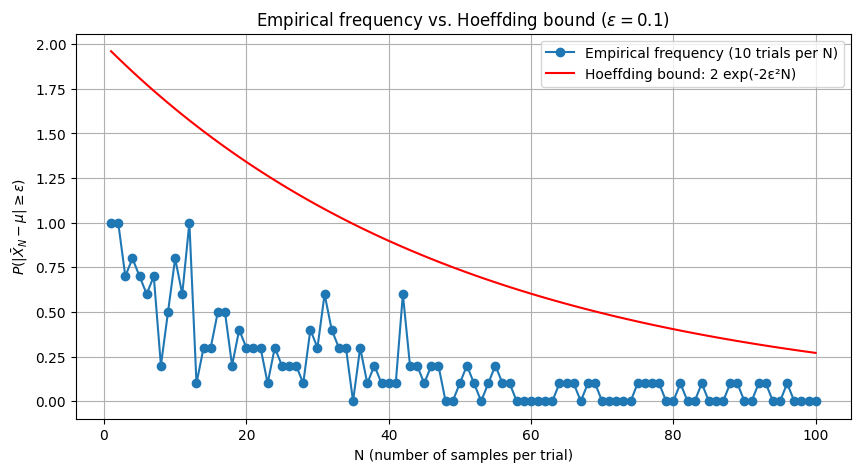

In [50]:
mu = 0.7
epsilon = 0.1

N_range = np.arange(1, 101)
observed_freq = []

num_trials_per_N = 10

for N in N_range:
    count_exceed = 0
    for _ in range(num_trials_per_N):
        samples = [sample_X() for _ in range(N)]
        X_bar = np.mean(samples)
        if abs(X_bar - mu) >= epsilon:
            count_exceed += 1
    observed_freq.append(count_exceed / num_trials_per_N)

hoeffding_bound = 2 * np.exp(-2 * (epsilon**2) * N_range)

plt.figure(figsize=(10,5))
plt.plot(N_range, observed_freq, 'o-', label='Empirical frequency (10 trials per N)')
plt.plot(N_range, hoeffding_bound, 'r-', label='Hoeffding bound: 2 exp(-2ε²N)')
plt.xlabel('N (number of samples per trial)')
plt.ylabel(r'$P(|\bar{X}_N-\mu| \geq \varepsilon)$')
plt.title(r'Empirical frequency vs. Hoeffding bound ($\varepsilon=0.1$)')
plt.legend()
plt.grid(True)
plt.show()


Part 3 (Extra): 3D Plot of P(|X̄ - μ| >= ε) for continuous X

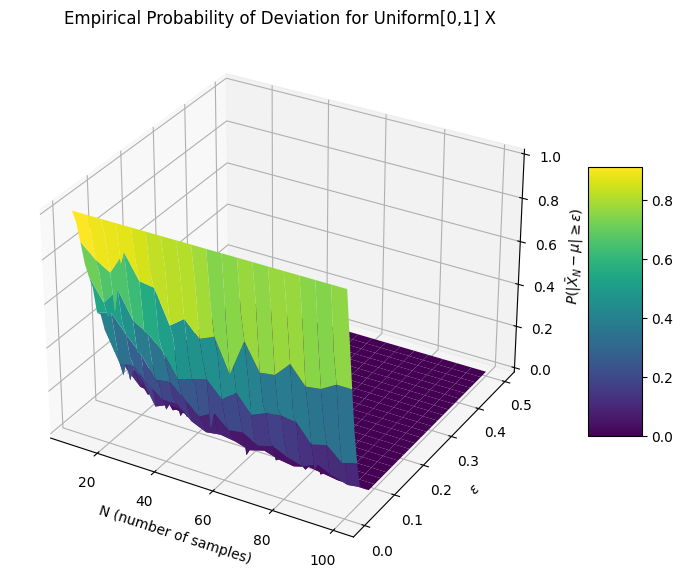

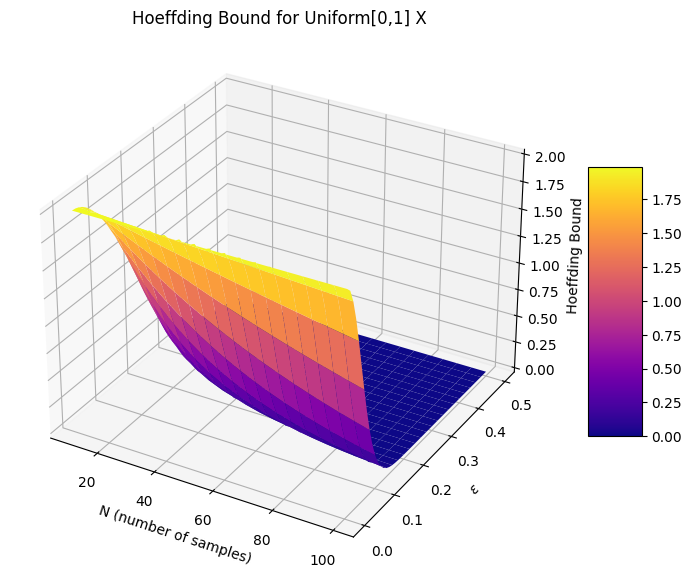

In [51]:
mu_cont = 0.5

def sample_X_cont():
    return random.random()

N_vals = np.arange(10, 101, 5)    
epsilons = np.linspace(0, 0.5, 51) 

prob_estimates = np.zeros((len(N_vals), len(epsilons)))

num_trials = 100
for i, N in enumerate(N_vals):
    for j, eps in enumerate(epsilons):
        count_exceed = 0
        for _ in range(num_trials):
            samples = [sample_X_cont() for _ in range(N)]
            X_bar = np.mean(samples)
            if abs(X_bar - mu_cont) >= eps:
                count_exceed += 1
        prob_estimates[i, j] = count_exceed / num_trials


from mpl_toolkits.mplot3d import Axes3D 

N_mesh, eps_mesh = np.meshgrid(N_vals, epsilons, indexing='ij')

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(N_mesh, eps_mesh, prob_estimates, cmap='viridis', edgecolor='none')
ax.set_xlabel('N (number of samples)')
ax.set_ylabel(r'$\varepsilon$')
ax.set_zlabel(r'$P(|\bar{X}_N-\mu| \geq \varepsilon)$')
ax.set_title('Empirical Probability of Deviation for Uniform[0,1] X')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

hoeffding_grid = 2 * np.exp(-2 * (eps_mesh**2) * N_mesh)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(N_mesh, eps_mesh, hoeffding_grid, cmap='plasma', edgecolor='none')
ax.set_xlabel('N (number of samples)')
ax.set_ylabel(r'$\varepsilon$')
ax.set_zlabel('Hoeffding Bound')
ax.set_title('Hoeffding Bound for Uniform[0,1] X')
fig.colorbar(surf2, shrink=0.5, aspect=5)
plt.show()


In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

random.seed(42)
np.random.seed(42)


def sample_coin1():
    return 1 if random.random() < 0.8 else 0

def sample_coin2():
    return 1 if random.random() < 0.4 else 0


def strategy_explore_then_commit_1(T):
    N = math.ceil(0.2 * T)
    rewards = []
    n1 = N // 2
    n2 = N - n1
    rewards_explore = []
    sum1 = sum(sample_coin1() for _ in range(n1))
    sum2 = sum(sample_coin2() for _ in range(n2))
    rewards_explore.append(sum1 + sum2)
    mean1 = sum1 / n1 if n1 > 0 else 0
    mean2 = sum2 / n2 if n2 > 0 else 0
    if mean1 >= mean2:
        rewards_commit = sum(sample_coin1() for _ in range(T - N))
    else:
        rewards_commit = sum(sample_coin2() for _ in range(T - N))
    total_reward = rewards_explore[0] + rewards_commit
    return total_reward


def strategy_explore_then_commit_2(T):
    N = math.ceil(0.5 * (T**(2/3)) * ((math.log(T))**(1/3)))
    rewards = []
    n1 = N // 2
    n2 = N - n1
    sum1 = sum(sample_coin1() for _ in range(n1))
    sum2 = sum(sample_coin2() for _ in range(n2))
    mean1 = sum1 / n1 if n1 > 0 else 0
    mean2 = sum2 / n2 if n2 > 0 else 0
    if mean1 >= mean2:
        rewards_commit = sum(sample_coin1() for _ in range(T - N))
    else:
        rewards_commit = sum(sample_coin2() for _ in range(T - N))
    total_reward = (sum1 + sum2) + rewards_commit
    return total_reward


def strategy_epsilon_greedy(T, epsilon=0.2):
    plays = {1: 0, 2: 0}
    sum_rewards = {1: 0, 2: 0}
    total_reward = 0
    r1 = sample_coin1()
    r2 = sample_coin2()
    total_reward += (r1 + r2)
    plays[1] += 1
    plays[2] += 1
    sum_rewards[1] += r1
    sum_rewards[2] += r2
    
    for t in range(3, T+1):
        mean1 = sum_rewards[1] / plays[1]
        mean2 = sum_rewards[2] / plays[2]
        if random.random() < (1 - epsilon):
            if mean1 >= mean2:
                chosen = 1
            else:
                chosen = 2
        else:
            chosen = 1 if (mean1 < mean2) else 2
        
        if chosen == 1:
            reward = sample_coin1()
        else:
            reward = sample_coin2()
        total_reward += reward
        plays[chosen] += 1
        sum_rewards[chosen] += reward
    return total_reward



def strategy_ucb(T):
    plays = {1: 0, 2: 0}
    sum_rewards = {1: 0, 2: 0}
    total_reward = 0
    r1 = sample_coin1()
    r2 = sample_coin2()
    total_reward += (r1 + r2)
    plays[1] += 1
    plays[2] += 1
    sum_rewards[1] += r1
    sum_rewards[2] += r2
    
    for t in range(3, T+1):
        ucb_values = {}
        for coin in [1, 2]:
            mean = sum_rewards[coin] / plays[coin]
            ucb = mean + math.sqrt(2 * math.log(t) / plays[coin])
            ucb_values[coin] = ucb
        chosen = max(ucb_values, key=ucb_values.get)
        if chosen == 1:
            reward = sample_coin1()
        else:
            reward = sample_coin2()
        total_reward += reward
        plays[chosen] += 1
        sum_rewards[chosen] += reward
    return total_reward



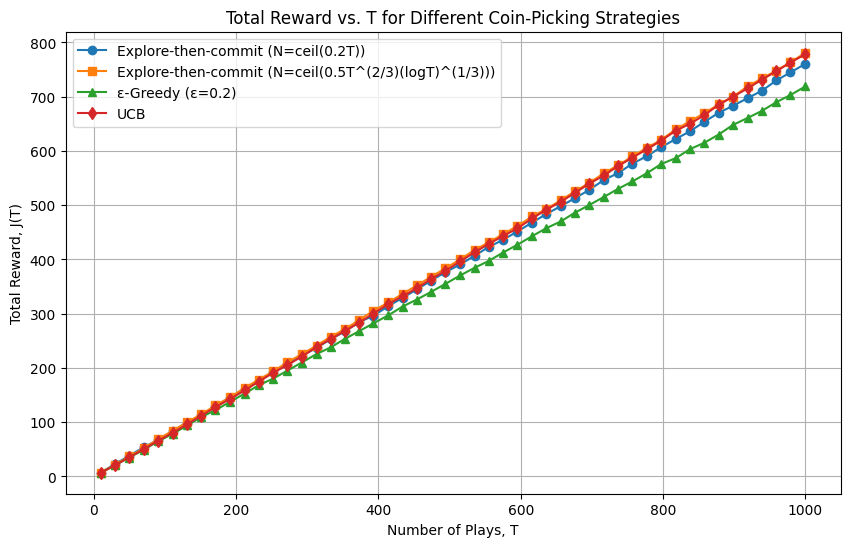

In [56]:
T_values = np.linspace(10, 1000, 50, dtype=int)  
num_simulations = 100

avg_rewards_et1 = []
avg_rewards_et2 = []
avg_rewards_eps = []
avg_rewards_ucb = []

for T in T_values:
    rewards_et1 = [strategy_explore_then_commit_1(T) for _ in range(num_simulations)]
    rewards_et2 = [strategy_explore_then_commit_2(T) for _ in range(num_simulations)]
    rewards_eps = [strategy_epsilon_greedy(T, epsilon=0.2) for _ in range(num_simulations)]
    rewards_ucb = [strategy_ucb(T) for _ in range(num_simulations)]
    
    avg_rewards_et1.append(np.mean(rewards_et1))
    avg_rewards_et2.append(np.mean(rewards_et2))
    avg_rewards_eps.append(np.mean(rewards_eps))
    avg_rewards_ucb.append(np.mean(rewards_ucb))

plt.figure(figsize=(10,6))
plt.plot(T_values, avg_rewards_et1, 'o-', label="Explore-then-commit (N=ceil(0.2T))")
plt.plot(T_values, avg_rewards_et2, 's-', label="Explore-then-commit (N=ceil(0.5T^(2/3)(logT)^(1/3)))")
plt.plot(T_values, avg_rewards_eps, '^-', label="ε-Greedy (ε=0.2)")
plt.plot(T_values, avg_rewards_ucb, 'd-', label="UCB")
plt.xlabel("Number of Plays, T")
plt.ylabel("Total Reward, J(T)")
plt.title("Total Reward vs. T for Different Coin-Picking Strategies")
plt.legend()
plt.grid(True)
plt.show()
